In [1]:
%load_ext autoreload
%autoreload 2

# Setup and Imports

In [2]:
from gcn import GCN
from gat import GAT
from loss import CrossEntropyLoss
import torch
import networkx as nx
import torch.nn.functional as F

# Gradient Testing for CrossEntropyLoss, GCN and GAT (Manual vs Autograd)

In [3]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt.double(), t.grad.double())
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [4]:
H_random = torch.rand(128,128)
H_random.requires_grad = True
A_random = torch.randint(0, 2, (128,128)) * 1.0
y_random = torch.randint(0, 17, (128,))

In [5]:
CE = CrossEntropyLoss()

In [6]:
H_random.grad = None
loss = CE.forward(H_random,y_random)
dloss = CE.backward(1)
loss.retain_grad()
loss.backward()
cmp("dloss", dloss, H_random)


dloss           | exact: True  | approximate: True  | maxdiff: 0.0


In [7]:
gcn = GCN(128, 128)

parameters = [H_random, gcn.W1, gcn.W2,gcn.b]


In [8]:
for p in parameters:
    p.requires_grad = True

for p in parameters:
    p.grad = None

logits = gcn.forward(H_random, A_random)
out = torch.sum(logits)
dH, dW1, dW2, db  = gcn.backward(torch.ones((128, 128)))


logits.retain_grad()

out.backward()
cmp("dH", dH, H_random)
cmp("dW1", dW1, gcn.W1)
cmp("dW2", dW2, gcn.W2)
cmp("db", db, gcn.b)

dH              | exact: True  | approximate: True  | maxdiff: 0.0
dW1             | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db              | exact: True  | approximate: True  | maxdiff: 0.0


In [9]:
gat = GAT(128, 128)

parameters = [H_random, gat.W, gat.b, gat.attention]


In [10]:
for p in parameters:
    p.requires_grad = True

for p in parameters:
    p.grad = None

logits = gat.forward(H_random, A_random)
out = torch.sum(logits)
dH, dW, db, dattention  = gat.backward(torch.ones((128, 128)))


logits.retain_grad()

out.backward()
cmp('dH', dH, H_random) # numerically inaccurate, double precision reduces error
cmp('dW', dW, gat.W)
cmp('db', db, gat.b)
cmp('dattention', dattention, gat.attention)

dH              | exact: False | approximate: False | maxdiff: 1.1920928955078125e-06
dW              | exact: False | approximate: True  | maxdiff: 1.52587890625e-05
db              | exact: False | approximate: True  | maxdiff: 1.52587890625e-05
dattention      | exact: True  | approximate: True  | maxdiff: 0.0


# Graph Data Preparation (Karate Club Dataset)

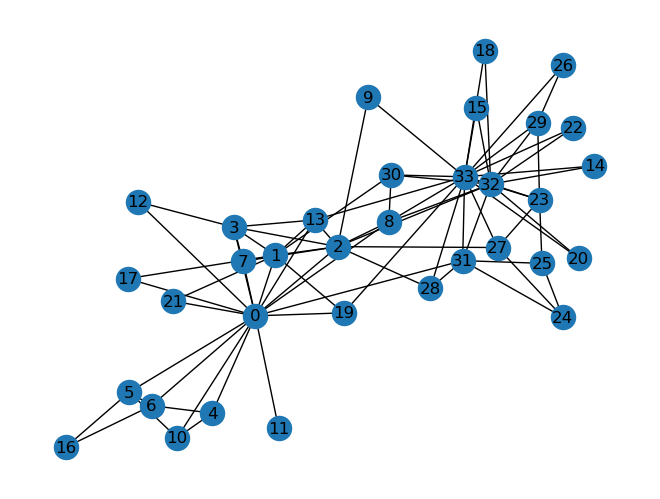

In [11]:
G = nx.karate_club_graph()
nx.draw(G, with_labels = True)


In [12]:
A = nx.adjacency_matrix(G, weight = None)
A = torch.tensor(A.toarray(), dtype=torch.float32)


V = G.nodes
V = F.one_hot(torch.arange(len(V))) * 1.0

y = []
for node in G.nodes(data=True):
    if node[1]['club'] == "Mr. Hi":
        y.append(0)
    else:
       y.append(1)

y = torch.tensor(y)



In [13]:
import matplotlib.pyplot as plt
import time
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    h = h.detach().cpu().numpy()
    h[h == -0.0] = 0.0
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                f'Training Accuracy: {accuracy*100:.2f}% \n'),
                fontsize=16)
    plt.show()

# Training a 2-Layer GCN

In [14]:
layersGCN = [
    GCN(34, 8),
    GCN(8, 2)
    ]

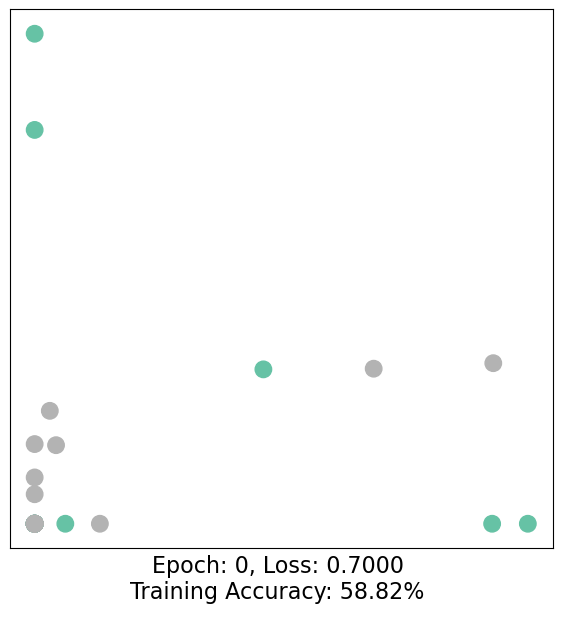

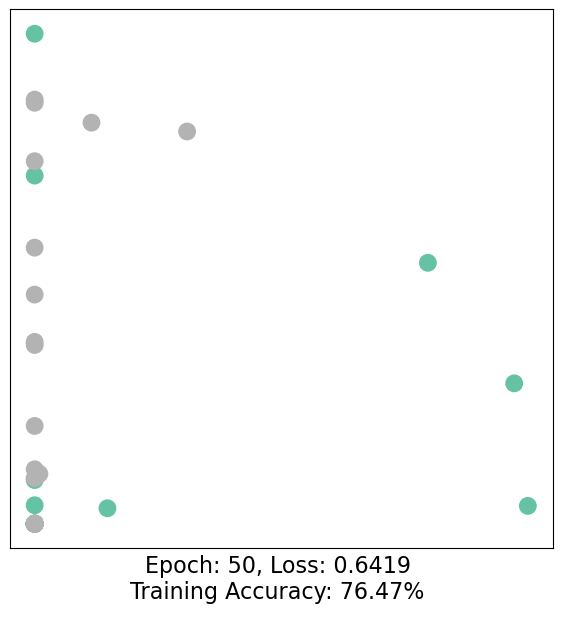

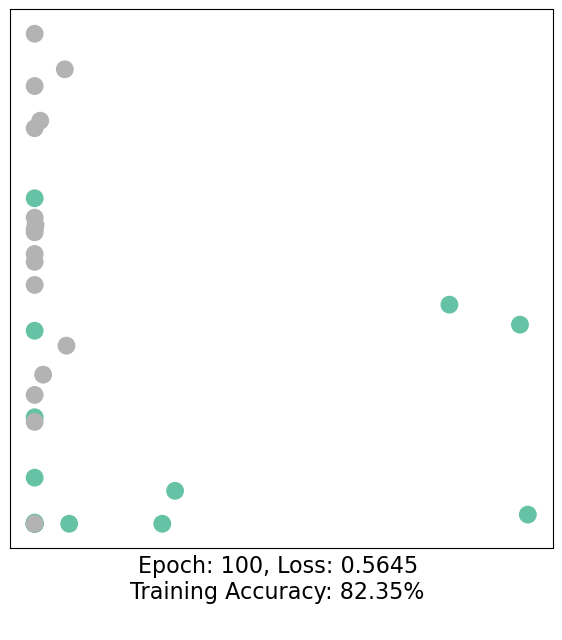

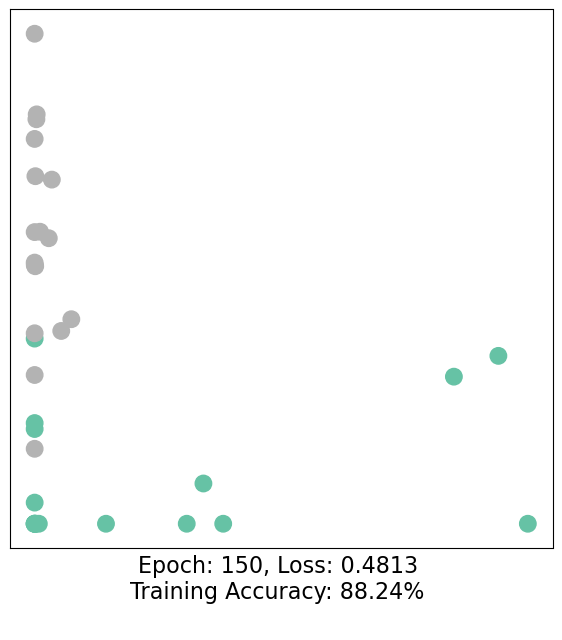

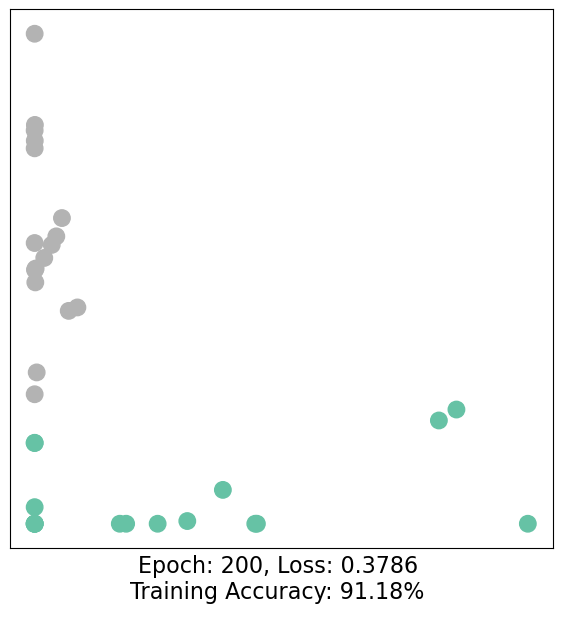

In [15]:
lr = 0.1
epochs = 250
CE = CrossEntropyLoss()

def train():
        for i in range(epochs):
            out0 = layersGCN[0].forward(V, A)
            logits = layersGCN[1].forward(out0, A)
            loss = CE.forward(logits, y)

            dlogits = CE.backward(1)
            dH1, dW11, dW12, db1 = layersGCN[1].backward(dlogits)
            dH0, dW01, dW02, db0 = layersGCN[0].backward(dH1)

            layersGCN[1].W1 -= lr * dW11
            layersGCN[1].W2 -= lr * dW12
            layersGCN[1].b -= lr * db1

            layersGCN[0].W1 -= lr * dW01
            layersGCN[0].W2 -= lr * dW02
            layersGCN[0].b -= lr * db0

            acc = torch.mean((torch.argmax(logits, dim=1) == y).float())
            #print(f"Epoch {i+1}, Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")
            if i % 50 == 0:
                visualize(logits, color=y, epoch=i, loss=loss, accuracy=acc)
                time.sleep(0.3)
train()

# Training a 2-Layer GAT


In [16]:
layersGAT = [
    GAT(34, 8),
    GAT(8, 2)
    ]

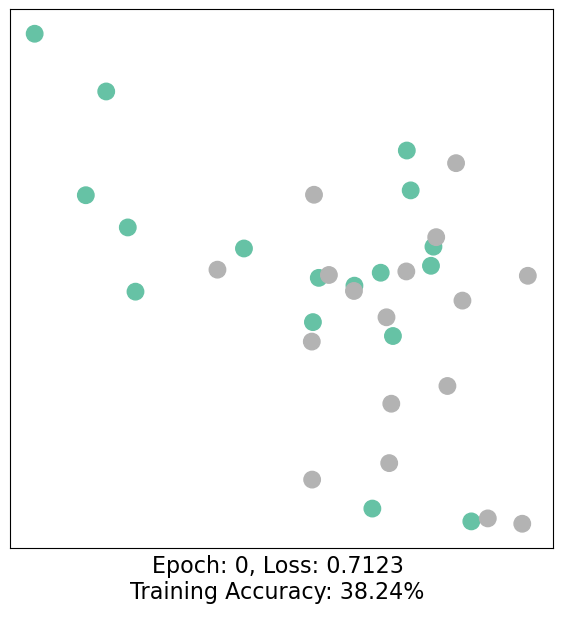

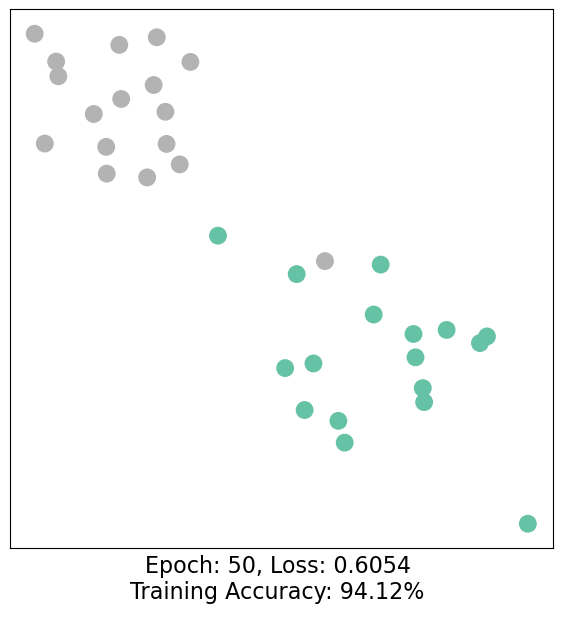

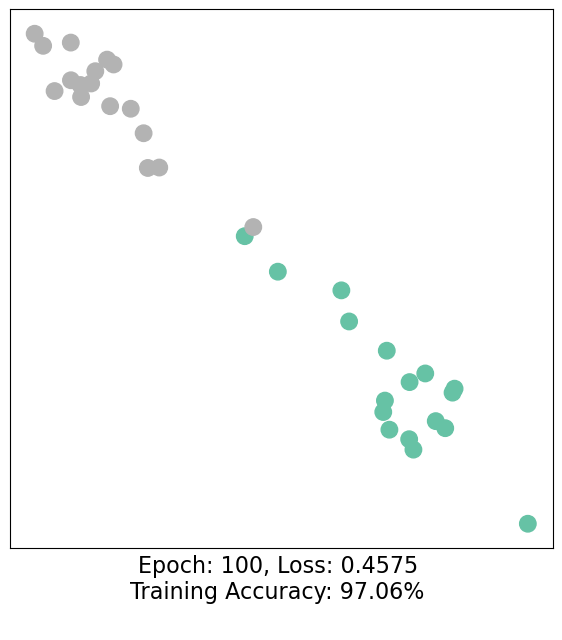

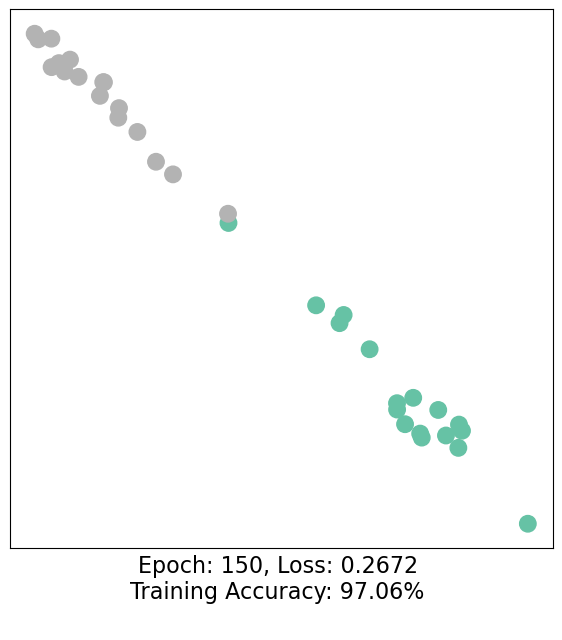

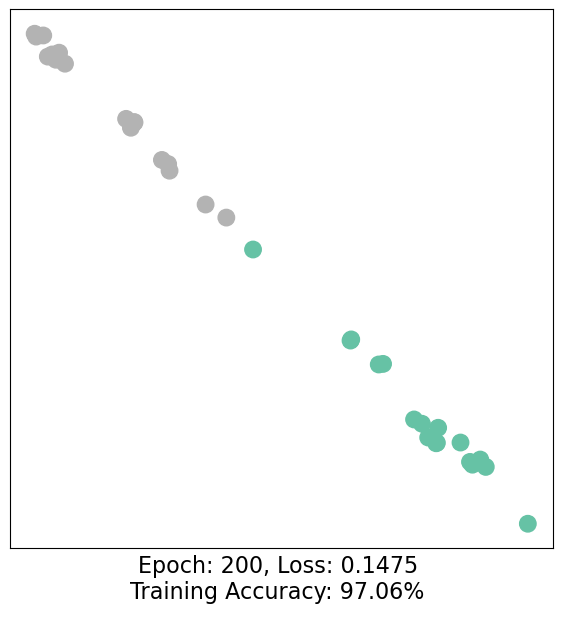

In [17]:
lr = 0.1
epochs = 250
CE = CrossEntropyLoss()

def train():
    for i in range(epochs):
        out0 = layersGAT[0].forward(V, A) # GAT 0 
        logits = layersGAT[1].forward(out0, A) # GAT 1
        loss = CE.forward(logits, y) # CrossEntropy

        dlogits = CE.backward(1) # CrossEntropy
        dH1, dW1, db1, dattention1 = layersGAT[1].backward(dlogits) #GCN 1
        dH0, dW0, db0, dattention0 = layersGAT[0].backward(dH1) #GCN 0

        layersGAT[1].W -= lr * dW1
        layersGAT[1].b -= lr * db1
        layersGAT[1].attention -= lr * dattention1

        layersGAT[0].W -= lr * dW0
        layersGAT[0].b -= lr * db0
        layersGAT[0].attention -= lr * dattention0

        acc = torch.mean(torch.where(torch.max(logits, dim = 1)[1] == y, 1.0, 0.0))

        if i % 50 == 0:
            visualize(logits, color=y, epoch=i, loss=loss, accuracy=acc)
            #time.sleep(0.3)
    
train()

In [ ]:
import torch

generator = torch.Generator()

y = torch.randn(3,2,generator=generator)
z1 = torch.randn(2, generator=generator)
z2 = torch.randn(1,2, generator=generator)
z3 = torch.randn(5, generator=generator)
y2 = torch.randn(2,5,generator=generator)
a = torch.randn(3,2,5,generator=generator)
b = torch.randn(3,5,3,generator=generator)
test = torch.tensor([[1,2],[3,4]])

print(y)
print(torch.einsum('ij->ji', y))
print(torch.einsum('ij->', y))
print(torch.einsum('ij->j', y))
print(torch.einsum('ij->i', y))
print(torch.einsum('ij, j->i', y,z1))
print(torch.einsum('ij, kj->ik', y, z2))
print(torch.einsum('ij, jk -> ik', y, y2))
print(torch.einsum('i,i->', y[0], y[0]))
print(torch.einsum('ij,ij->i', y, y))
print(torch.einsum('ij,ij->ij', y, y))
print(torch.einsum('i,j->ij', z1, z3))
print(torch.einsum('ijk, ikl ->ijl', a, b))


tensor([[1, 2],
        [3, 4]])
tensor([[ 0.9773,  1.1569],
        [-0.3807,  1.2525],
        [-0.3068, -1.4705]])
tensor([[ 0.9773, -0.3807, -0.3068],
        [ 1.1569,  1.2525, -1.4705]])
tensor(1.2286)
tensor([0.2898, 0.9389])
tensor([ 2.1341,  0.8718, -1.7773])
tensor([ 1.1932,  2.8133, -2.5059])
tensor([[-2.3314],
        [-1.7536],
        [ 2.4625]])
tensor([[-0.7219,  0.5718, -2.1485, -0.5603,  1.2880],
        [ 2.9804,  0.0401, -2.7235, -0.6319,  1.0263],
        [-1.5282, -0.3504,  2.9894,  0.7286, -1.3978]])
tensor(2.2934)
tensor([2.2934, 1.7137, 2.2565])
tensor([[0.9550, 1.3383],
        [0.1449, 1.5688],
        [0.0942, 2.1624]])
tensor([[ 0.2153, -0.0326, -1.8926, -0.5457,  1.6366],
        [-0.3918,  0.0594,  3.4447,  0.9933, -2.9787]])
tensor([[[-0.9553,  1.2860,  2.1116],
         [ 1.0563,  0.8132,  0.8337]],

        [[ 0.1397,  0.4867,  0.8163],
         [ 1.0606,  1.4575, -1.1123]],

        [[-1.6532, -1.6857,  0.7888],
         [-5.6188,  1.6934,  1.4081]]])